### Content-based recommendation system

1. Import potrzebnych bibliotek

In [1]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine, text
import sklearn.feature_extraction.text as sk_text
import sklearn.metrics.pairwise as sk_pairwise
from sklearn.metrics import mean_squared_error, mean_absolute_error

2. Wczytanie danych

In [2]:
# Connect to PostgreSQL server
host= "localhost"
database="movierecommenderdb"
user= "postgres"
password= "postgres"
port= "5432"


alchemyEngine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')
 
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect()

# Read data from PostgreSQL database table and load into a DataFrame instance
query_movies = text('SELECT * FROM "Movies"')
query_credits = text('SELECT * FROM "Credits"')
query_keywords = text('SELECT * FROM "Keywords"')
query_ratings = text('SELECT * FROM "Ratings"')
df_movie = pd.read_sql_query(query_movies, dbConnection)
df_credits = pd.read_sql_query(query_credits, dbConnection)
df_keywords = pd.read_sql_query(query_keywords, dbConnection)
df_ratings = pd.read_sql_query(query_ratings, dbConnection)

pd.set_option('display.expand_frame_repr', False)

# Close the database connection
dbConnection.close()

In [3]:
df_credits.head(3)

,cast,director,movieId
0,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,862
1,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,8844
2,"Al Pacino, Robert De Niro, Val Kilmer, Jon Voi...",Michael Mann,949


In [4]:
df_keywords.head(3)

,movieId,keywords
0,862,"jealousy, toy, boy, friendship, friends, rival..."
1,8844,"board game, disappearance, based on children's..."
2,949,"robbery, detective, bank, obsession, chase, sh..."


In [5]:
#sprawdz czy movieId jest unikalne
df_movie.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'movieId', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count',
       'poster_path', 'IMBD_poster_path', 'IMBD_backdrop_path'],
      dtype='object')

In [6]:
df_movie.head(3)

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,poster_path,IMBD_poster_path,IMBD_backdrop_path
0,False,Toy Story Collection,30000000,"Animation, Comedy, Family",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,English,Released,None,Toy Story,False,7.7,5415.0,https://image.tmdb.org/t/p/original/uXDfjJbdP4...,https://image.tmdb.org/t/p/w500//7G9915LfUQ2lV...,https://image.tmdb.org/t/p/w500//9FBwqcd9IRruE...
1,False,None,65000000,"Adventure, Fantasy, Family",None,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"English, Français",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,https://image.tmdb.org/t/p/original/nLXYV4WmYU...,None,None
2,False,None,60000000,"Action, Crime, Drama, Thriller",None,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,"English, Español",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,https://image.tmdb.org/t/p/original/umSVjVdbVw...,None,None


In [7]:
df_ratings.head(3)

,userId,movieId,rating,timestamp,normalized_rating,ratingID
0,24,2,3.0,979974023,0.555556,1
1,24,6,4.0,979870499,0.777778,2
2,24,16,3.0,979870379,0.555556,3


In [8]:
#merge movies and ratings
df_ratings = pd.merge(df_movie, df_ratings, on='movieId')
#let only necessary columns
df_ratings = df_ratings[['userId','movieId', 'title', 'normalized_rating', 'rating']]
df_ratings.head(3)

,userId,movieId,title,normalized_rating,rating
0,2103,862,Toy Story,1.000000,5.0
1,5380,862,Toy Story,0.111111,1.0
2,6525,862,Toy Story,0.777778,4.0


In [9]:
#check how many unique users and movies we have
print('Number of unique users: ', df_ratings.userId.nunique())
print('Number of unique movies: ', df_ratings.movieId.nunique())

Number of unique users:  16679
Number of unique movies:  7293


3. Przygotowanie i czyszczenie danych

In [10]:
#merge df_movie, df_credits, df_keywords
df_movie = df_movie.merge(df_credits, on='movieId')
df_movie = df_movie.merge(df_keywords, on='movieId')
df_movies_explore = df_movie.copy()

In [11]:
#let only the columns we need
df_movie = df_movie[['movieId','title','overview','genres','keywords','cast','director', 'poster_path', 'release_date', 'popularity']]
df_movie.head()

,movieId,title,overview,genres,keywords,cast,director,poster_path,release_date,popularity
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","Animation, Comedy, Family","jealousy, toy, boy, friendship, friends, rival...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,https://image.tmdb.org/t/p/original/uXDfjJbdP4...,1995.0,21.946943
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family","board game, disappearance, based on children's...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,https://image.tmdb.org/t/p/original/nLXYV4WmYU...,1995.0,17.015539
2,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","Action, Crime, Drama, Thriller","robbery, detective, bank, obsession, chase, sh...","Al Pacino, Robert De Niro, Val Kilmer, Jon Voi...",Michael Mann,https://image.tmdb.org/t/p/original/umSVjVdbVw...,1995.0,17.924927
3,710,GoldenEye,James Bond must unmask the mysterious head of ...,"Adventure, Action, Thriller","cuba, falsely accused, secret identity, comput...","Pierce Brosnan, Sean Bean, Izabella Scorupco, ...",Martin Campbell,https://image.tmdb.org/t/p/original/z0ljRnNxIO...,1995.0,14.686036
4,1408,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...","Action, Adventure","exotic island, treasure, map, ship, scalp, pirate","Geena Davis, Matthew Modine, Frank Langella, M...",Renny Harlin,https://image.tmdb.org/t/p/original/8g4sF1Qthl...,1995.0,7.284477


In [12]:
df_movie['combined_features'] = df_movie['genres'] + "-" + df_movie['keywords'] + "-" + df_movie['cast'] + "-" + df_movie['director']
df_movie['combined_features'] = df_movie['combined_features'].str.lower().str.replace(" ", "").str.replace(",", " ").str.replace("-", " ")
df_movie['combined_features'][1]

"adventure fantasy family boardgame disappearance basedonchildren'sbook newhome recluse giantinsect robinwilliams jonathanhyde kirstendunst bradleypierce bonniehunt bebeneuwirth davidalangrier patriciaclarkson adamhann byrd laurabellbundy jameshandy gillianbarber brandonobray cyrusthiedeke garyjosephthorup leonardzola lloydberry malcolmstewart annabelkershaw darrylhenriques robyndriscoll peterbryant sarahgilson floricavlad junelion brendalockmuller joejohnston"

In [13]:
df_movie.shape

(7409, 11)

4. EDA

In [14]:
#exploratory data analysis
df_movies_explore.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'movieId', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count',
       'poster_path', 'IMBD_poster_path', 'IMBD_backdrop_path', 'cast',
       'director', 'keywords'],
      dtype='object')

Text(0.5, 1.0, 'Most popular movies')

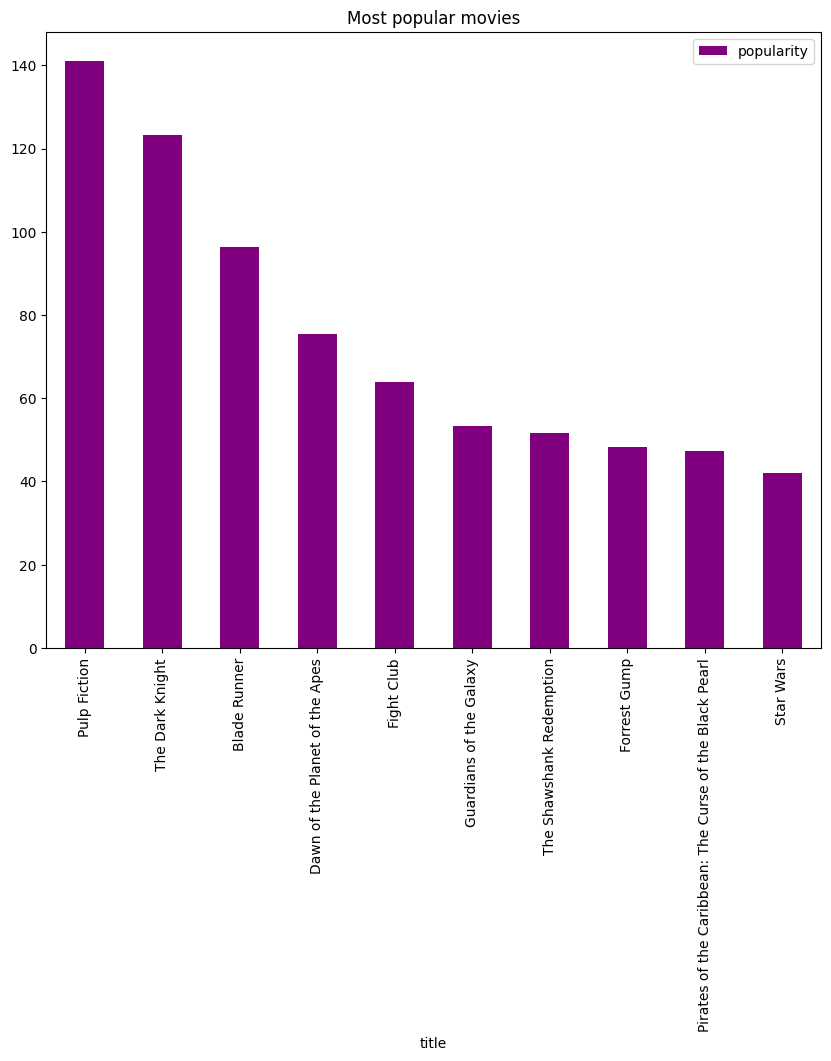

In [15]:
import matplotlib.pyplot as plt

#plot most popular movies
df_movies_explore['popularity'].describe()

#change popularity to float
df_movies_explore['popularity'] = pd.to_numeric(df_movies_explore['popularity'], errors='coerce')

most_popular_movies = df_movies_explore.sort_values(by='popularity', ascending=False)[['title','popularity']].head(10)
most_popular_movies.plot(kind='bar', x='title', y='popularity',color = 'purple', figsize=(10,8))
plt.title('Most popular movies')

Text(0.5, 1.0, 'Most rated movies')

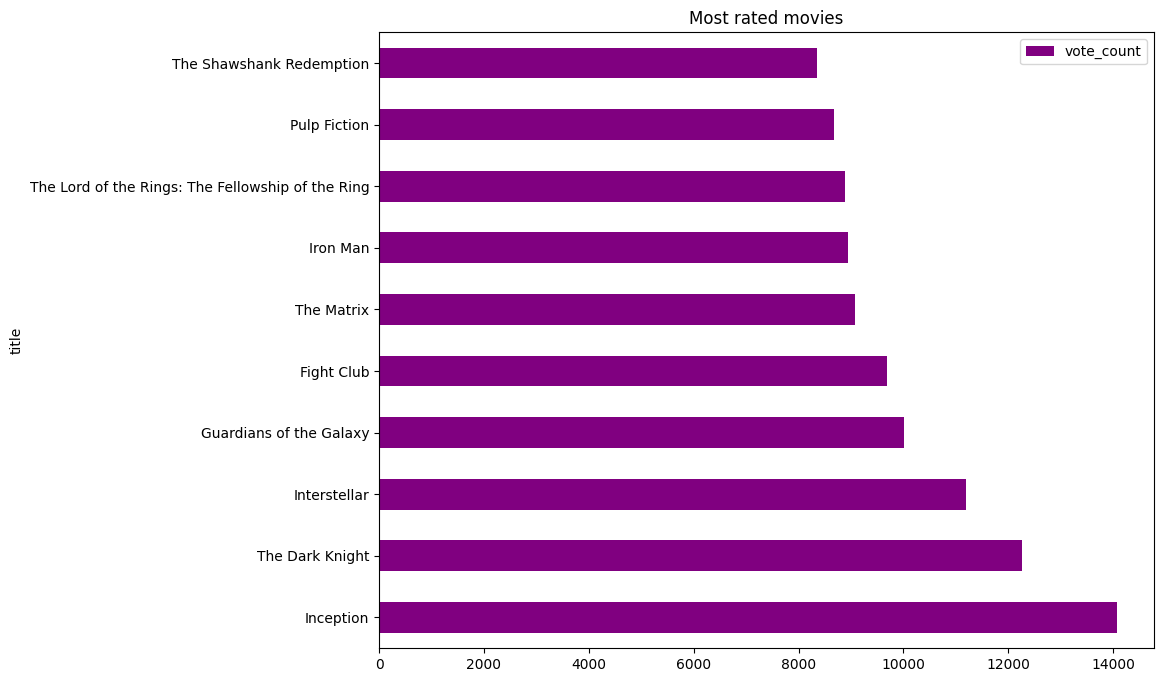

In [16]:
#mark empty values as null
df_movies_explore['vote_average'] = pd.to_numeric(df_movies_explore['vote_average'], errors='coerce')
df_movies_explore['vote_count'] = pd.to_numeric(df_movies_explore['vote_count'], errors='coerce')

#plot most rated movies
most_rated_movies = df_movies_explore.sort_values(by='vote_count', ascending=False)[['title','vote_count']].head(10)
most_rated_movies.plot(kind='barh', x='title', y='vote_count',color = 'purple', figsize=(10,8))
plt.title('Most rated movies')


In [17]:
#most popular directors
df_movies_explore['director'].tolist()
print(df_movies_explore['director'].isnull().sum())

78


5. Ekstrakcja cech

In [18]:
df_movie['combined_features'] = df_movie['combined_features'].values.astype('U')

In [19]:
#convert combined column from text to feature vector
vectorizer = sk_text.TfidfVectorizer(stop_words='english')
print(vectorizer)
X = vectorizer.fit_transform(df_movie['combined_features'])
print(X)

TfidfVectorizer(stop_words='english')
  (0, 31478)	0.2165717593258133
  (0, 49192)	0.22989888066313754
  (0, 56037)	0.2404772119809186
  (0, 36885)	0.19600139945738448
  (0, 36704)	0.18790965117662886
  (0, 18610)	0.2404772119809186
  (0, 31594)	0.2404772119809186
  (0, 3454)	0.2223934351495152
  (0, 31758)	0.18790965117662886
  (0, 64943)	0.1846442229844968
  (0, 30383)	0.2165717593258133
  (0, 16168)	0.2165717593258133
  (0, 61791)	0.20779340891529038
  (0, 62310)	0.17675790391596033
  (0, 62916)	0.2223934351495152
  (0, 46103)	0.22989888066313754
  (0, 7156)	0.2223934351495152
  (0, 53192)	0.18174241566322982
  (0, 21046)	0.16733929130820005
  (0, 21047)	0.13569228858550028
  (0, 7138)	0.1846442229844968
  (0, 62914)	0.2165717593258133
  (0, 29037)	0.14735033433363343
  (0, 19393)	0.10456497337357532
  (0, 12014)	0.06645762529535518
  :	:
  (7405, 4066)	0.22688922914626286
  (7405, 59002)	0.2661286090795957
  (7405, 65284)	0.17187508426911696
  (7405, 45199)	0.13669153911285847
  (7

In [20]:
X.shape

(7409, 67225)

6. Miara podobieństwa

In [21]:
#finding the similarity scores between movies using cosine similarity
cosine_sim = sk_pairwise.cosine_similarity(X, X)
print(cosine_sim)

[[1.         0.00814049 0.         ... 0.         0.         0.        ]
 [0.00814049 1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.00132687]
 ...
 [0.         0.         0.         ... 1.         1.         0.        ]
 [0.         0.         0.         ... 1.         1.         0.        ]
 [0.         0.         0.00132687 ... 0.         0.         1.        ]]


In [22]:
cosine_sim.shape

(7409, 7409)

7. Rekomendacje

In [23]:
def get_recommendations(title, cosine_sim=cosine_sim, top_n=30):
    idx = df_movie[df_movie['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]
    movie_indices = [i[0] for i in sim_scores]
    recommendations_df = pd.DataFrame({
        'title': df_movie['title'].iloc[movie_indices],
        'similarity_score': [x[1] for x in sim_scores],
        'poster_url': df_movie['poster_path'].iloc[movie_indices],
        'genres': df_movie['genres'].iloc[movie_indices],
        'release_date': df_movie['release_date'].iloc[movie_indices],
        'overview': df_movie['overview'].iloc[movie_indices],
        'cast': df_movie['cast'].iloc[movie_indices],
        'director': df_movie['director'].iloc[movie_indices],
        'popularity': df_movie['popularity'].iloc[movie_indices]
    })
    
    return recommendations_df

df_recommendations = get_recommendations('Toy Story')
df_recommendations = df_recommendations['title'].tolist()
df_recommendations

['Dr. Otto and the Riddle of the Gloom Beam',
 'Cars',
 'Cars 2',
 'Ernest Saves Christmas',
 'Who Is Cletis Tout?',
 'Big',
 'Monsters, Inc.',
 'Arctic Tale',
 'Meet the Robinsons',
 'Feed the Kitty',
 'The Flintstones',
 'Kit Kittredge: An American Girl',
 'Shooting War',
 'Chimpanzee',
 'Micki & Maude',
 'The Polar Express',
 'Beach Blanket Bingo',
 'December Boys',
 'Minuscule: Valley of the Lost Ants',
 'Lovesick',
 'Larry Crowne',
 '3 Ninjas: High Noon at Mega Mountain',
 'Steamboy',
 'Treasure Planet',
 'Galaxy Quest',
 'My Best Friend',
 'Mass Effect: Paragon Lost',
 'Ratatouille',
 'Titan A.E.',
 "Happily N'Ever After"]

In [24]:
#check which user rated the most movies
df_ratings['userId'].value_counts().head(10)

45811     3526
8659      2956
179792    2520
107720    2047
270123    1996
229879    1926
243443    1852
228291    1832
70648     1797
172224    1781
Name: userId, dtype: int64

In [25]:
def evaluate_recommendations(user_id, recommended_movies, ratings_df):
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    # Filter the user's ratings for the recommended movies
    user_ratings = user_ratings[user_ratings['title'].isin(recommended_movies)]
    
    if user_ratings.empty:
        #print("User has not rated any of the recommended movies.")
        return 0.0, 0.0
    
    true_ratings = user_ratings['normalized_rating']
    predicted_ratings = user_ratings.apply(lambda row: 1.0 if row['title'] in recommended_movies else 0.0, axis=1)
    
    mse = mean_squared_error(true_ratings, predicted_ratings)
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    
    return mse, mae

def evaluation(user_id):
    user_ratings = df_ratings[df_ratings['userId'] == user_id]
    #print(f"User {user_id} has rated {user_ratings.shape[0]} movies.")
    mse_error = []
    mae_error = []

    for idx, row in user_ratings.iterrows():
        movie_id = row['movieId']
        #print(f"User {user_id}, Movie {movie_id}")
        movie_title = df_movie[df_movie['movieId'] == movie_id]['title'].values[0]
        #print(f"Movie title: {movie_title}")
        recommended_movies = get_recommendations(movie_title)['title'].tolist()
        #print(recommended_movies)
        mse, mae = evaluate_recommendations(user_id, recommended_movies, df_ratings)
        #print(f"User {user_id}, Movie {row['movieId']}: MSE = {mse}, MAE = {mae}")
        mse_error.append(mse)
        mae_error.append(mae)
        
    return mse_error, mae_error


In [26]:
# Example usage for a user with userId 24
user_id = 45811
mse_error, mae_error = evaluation(user_id)
print(f"Average MSE error for user {user_id}: {np.mean(mse_error)}")
print(f"Average MAE error for user {user_id}: {np.mean(mae_error)}")

Average MSE error for user 45811: 0.20150961847029356
Average MAE error for user 45811: 0.40425024188041525


In [104]:
#show evaluation for all users
user_ids = df_ratings['userId'].unique()
mse_errors = []
mae_errors = []

for user_id in user_ids:
    mse_error, mae_error = evaluation(user_id)
    mse_errors.append(np.mean(mse_error))
    mae_errors.append(np.mean(mae_error))
    
print(f"Average MSE error for all users: {np.mean(mse_errors)}")
print(f"Average MAE error for all users: {np.mean(mae_errors)}")

#plot MSE and MAE errors
plt.figure(figsize=(10, 8))
plt.plot(mse_errors, label='MSE')
plt.plot(mae_errors, label='MAE')
plt.legend()
plt.title('MSE and MAE errors')
plt.xlabel('User ID')
plt.ylabel('Error')
plt.show()


KeyboardInterrupt: 

In [21]:
from matplotlib import cm
def get_pie_plot_of_genres(df):
    df['genre'] = df['genres'].apply(lambda x: x.split(","))
    df['genre'] = df['genre'].apply(lambda x: [i.replace(" ", "") for i in x])
    
    genres = []
    for i in df['genre']:
        genres.extend(i)
    genres = list(set(genres))

    genres_count = {}
    for i in genres:
        genres_count[i] = 0
    for i in df['genre']:
        for j in i:
            genres_count[j] += 1
            
    plt.figure(figsize=(10,10))
    colors = cm.rainbow(np.linspace(0, 1, len(genres_count.keys())))
    plt.pie(genres_count.values(), labels=genres_count.keys(), autopct='%1.1f%%', startangle=90, pctdistance=0.85, textprops={'fontsize': 10}, colors=colors)
    plt.legend(labels=genres_count.keys(), loc='upper right', bbox_to_anchor=(1.2, 1.0))
    plt.title('Genres')
    plt.show()


C:\Users\aldabrow\AppData\Local\Temp\ipykernel_17016\730271730.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(x) for x in vals])


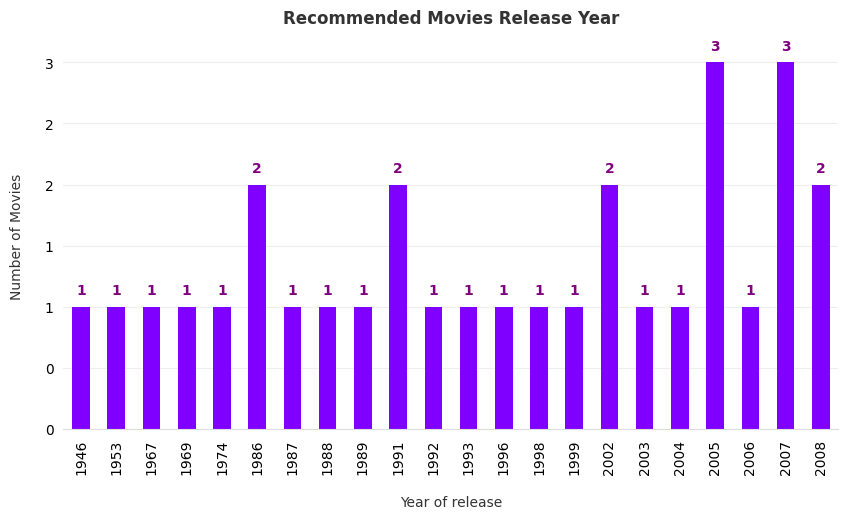

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def get_bar_plot_of_release_dates(df):
    
    df['year'] = df['release_date'].fillna(0).astype(int)
    df_counts = df['year'].value_counts().sort_index().reset_index()
    df_counts.columns = ['Year', 'Number of Movies']

    df_filtered = df_counts[df_counts['Number of Movies'] > 0]
    
    plt.rcParams['figure.figsize'] = (10, 5)
    
    ax = df_filtered.plot(kind='bar', x='Year', y='Number of Movies', colormap = cm.rainbow, legend=False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    
    ax.tick_params(bottom=False, left=False)
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 0.1), ha='center', color='purple', weight='bold')
    
    vals = ax.get_yticks()
    ax.set_yticklabels([int(x) for x in vals])
    
    ax.set_xlabel('Year of release', labelpad=15, color='#333333')
    ax.set_ylabel('Number of Movies', labelpad=15, color='#333333')
    ax.set_title('Recommended Movies Release Year', pad=15, color='#333333', weight='bold')
    
    plt.show()

get_bar_plot_of_release_dates(df_recommendations)


In [24]:
def get_horizontal_bar_plot_of_cast(df):
    df['casts'] = df['cast'].apply(lambda x: x.split(","))
    cast = []
    for i in df['casts']:
        cast.extend(i) 
    cast = [i.strip() for i in cast]
    cast_count = pd.Series(cast).value_counts()
    
    cast_count_filtered = cast_count.sort_values(ascending=False).head(10)
    cast_count_filtered = cast_count_filtered[::-1]
    
    plt.figure(figsize=(10, 5))  
    ax = cast_count_filtered.plot(kind='barh', colormap=cm.rainbow)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    
    ax.tick_params(bottom=False, left=False)
    
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, color='#EEEEEE')
    ax.yaxis.grid(False)
    
    for p in ax.patches:
        ax.annotate(str(p.get_width()), (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), va='center', color='black', weight='bold')
    
    vals = ax.get_xticks()
    ax.set_xticklabels([int(x) for x in vals], color='#333333')
    
    ax.set_ylabel('Cast Member', labelpad=15, color='#333333')
    ax.set_xlabel('Number of Movies', labelpad=15, color='#333333')
    ax.set_title('Top 10 Cast Actors', pad=15, color='#333333', weight='bold', fontsize=15)
    plt.show()

C:\Users\aldabrow\AppData\Local\Temp\ipykernel_17016\521690296.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x) for x in vals], color='#333333')


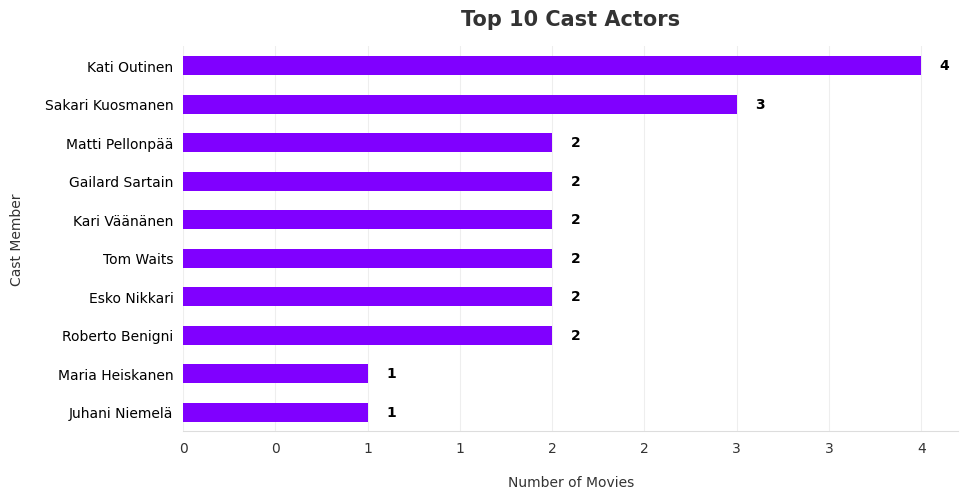

In [25]:
get_horizontal_bar_plot_of_cast(df_recommendations)

In [26]:
from mycolorpy import colorlist as mcp
import numpy as np
color1=mcp.gen_color(cmap="rainbow",n=10)
print(color1)

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def create_directors_network_graph(df):
    df['directors'] = df['director'].astype(str)
    df['directors'] = df['directors'].apply(lambda x: x.split(","))
    df['directors'] = df['directors'].apply(lambda x: [i.strip() for i in x])
    
    directors = []
    for i in df['directors']:
        directors.extend(i)
    directors_count = pd.Series(directors).value_counts()
    
    directors_count_filtered = directors_count[directors_count >= 2]
    
    G = nx.Graph()

    for index, row in df.iterrows():
        for director in row['directors']:
            if director in directors_count_filtered.index:
                G.add_node(director, bipartite=0)  # 0 for directors
                G.add_node(row['title'], bipartite=1)  # 1 for movies
                G.add_edge(director, row['title'])

    plt.figure(figsize=(12, 8))

    pos = nx.bipartite_layout(G, nodes=directors_count_filtered.index, align='vertical', scale=0.5)
    directors_nodes = {node for node, data in G.nodes(data=True) if data['bipartite'] == 0}
    movies_nodes = {node for node, data in G.nodes(data=True) if data['bipartite'] == 1}
    label_pos = {k: [v[0], v[1] + 0.05] for k, v in pos.items()}

    nx.draw_networkx_nodes(G, pos, nodelist=directors_nodes, node_color='#10a2f0', node_size=1500, alpha=0.9)
    nx.draw_networkx_nodes(G, pos, nodelist=movies_nodes, node_color='#ff562c', node_size=800, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, label_pos, font_size=10, font_family='Arial', font_color='black')

    plt.title('Most frequently appearing directors on Director-Movie Graph', fontsize=15, fontweight='bold', pad=15, color='#333333')
    plt.axis('off')
    plt.savefig('directors.png')
    plt.close()

create_directors_network_graph(df_recommendations)


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def get_most_popular_movies(df):
    df_sorted = df.sort_values(by='popularity', ascending=False).head(15)
    my_range = range(1, len(df_sorted) + 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.hlines(y=my_range, xmin=0, xmax=df_sorted['popularity'], color='#007ACC', alpha=0.4, linewidth=10)
    plt.plot(df_sorted['popularity'], my_range, "o", markersize=10, color='#007ACC', alpha=0.8)
    ax.set_xlabel('Popularity',labelpad=15, color='#333333', fontsize=12)
    ax.set_ylabel('Movie Title',labelpad=15, color='#333333', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.yticks(my_range, df_sorted['title'], fontsize=10, fontweight='black', color='#333333')
    plt.title('Top Most Popular Movies', fontsize=15, fontweight='bold', color='#333333', pad=15)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds((1, len(my_range)))
    ax.set_xlim(0, max(df_sorted['popularity']) + 1)

    ax.spines['left'].set_position(('outward', 8))
    ax.spines['bottom'].set_position(('outward', 5))

    plt.close()

In [29]:
def get_recommendations_for_two_users(title1, title2, cosine_sim=cosine_sim, top_n=30):
    idx1 = df_movie[df_movie['title'] == title1].index[0]
    idx2 = df_movie[df_movie['title'] == title2].index[0]
    
    # Calculate cosine similarity between the two provided movies
    combined_similarity = cosine_sim[idx1] * cosine_sim[idx2]
    
    # Get movie indices sorted by combined similarity
    sim_scores = list(enumerate(combined_similarity))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]
    movie_indices = [i[0] for i in sim_scores]
    
    recommendations_df = pd.DataFrame({
        'title': df_movie['title'].iloc[movie_indices],
        'similarity_score': [x[1] for x in sim_scores],
        'poster_url': df_movie['poster_path'].iloc[movie_indices],
        'genres': df_movie['genres'].iloc[movie_indices],
        'release_date': df_movie['release_date'].iloc[movie_indices],
        'overview': df_movie['overview'].iloc[movie_indices]
    })
    
    return recommendations_df


get_recommendations_for_two_users('Toy Story', 'The Dark Knight')

,title,similarity_score,poster_url,genres,release_date,overview
2892,TMNT,0.000924,https://image.tmdb.org/t/p/original/ksguZE9rTt...,"Adventure, Animation, Comedy, Family",2007.0,"After the defeat of their old arch nemesis, Th..."
3898,Cars 2,0.000622,https://image.tmdb.org/t/p/original/okIz1HyxeV...,"Animation, Family, Adventure, Comedy",2011.0,Star race car Lightning McQueen and his pal Ma...
373,Prefontaine,0.000614,https://image.tmdb.org/t/p/original/1sSf0n8dbd...,"Drama, Romance",1997.0,It's the true-life story of legendary track st...
1473,Who Is Cletis Tout?,0.000605,https://image.tmdb.org/t/p/original/udHRTgyZa1...,"Action, Comedy, Crime",2001.0,A comedy about a hitman who sees everything in...
1462,The Powerpuff Girls Movie,0.000587,https://image.tmdb.org/t/p/original/n854BOogVQ...,"Animation, Action, Family",2002.0,The Powerpuff Girls Movie tells the origin sto...
2765,Hollywoodland,0.000570,https://image.tmdb.org/t/p/original/iHSbYI7l9I...,"Drama, Thriller, Crime",2006.0,The complicated life and controversial suicide...
770,Superman II,0.000517,https://image.tmdb.org/t/p/original/jw0tYFCbzj...,"Action, Adventure, Fantasy, Science Fiction",1980.0,Three escaped criminals from the planet Krypto...
2797,The Prestige,0.000504,https://image.tmdb.org/t/p/original/tRNlZbgNCN...,"Drama, Mystery, Thriller",2006.0,A mysterious story of two magicians whose inte...
4154,Superman vs. The Elite,0.000436,https://image.tmdb.org/t/p/original/kozJARWRoG...,"Animation, Action",2012.0,The Man of Steel finds himself outshone by a n...
769,Superman,0.000429,https://image.tmdb.org/t/p/original/d7px1FQxW4...,"Action, Adventure, Fantasy, Science Fiction",1978.0,Mild-mannered Clark Kent works as a reporter a...


https://medium.com/geekculture/creating-content-based-movie-recommender-with-python-7f7d1b739c63 nice article to take a look at 